In [2]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import tensorflow as tf
from typing import Iterable, List
import numpy as np
import math
from SpatialPooler import SpatialPooler
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from util.metrics import get_mean_similiraty, similiraty_to_percent, get_similiraty
from util.plots import plot_images, plot_image
from util.data import sample_class, encode_img, get_sp_sdr_test_set

2022-11-21 14:35:09.067074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 14:35:09.151712: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 14:35:09.578474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-21 14:35:09.578527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

<IPython.core.display.Javascript object>

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

<IPython.core.display.Javascript object>

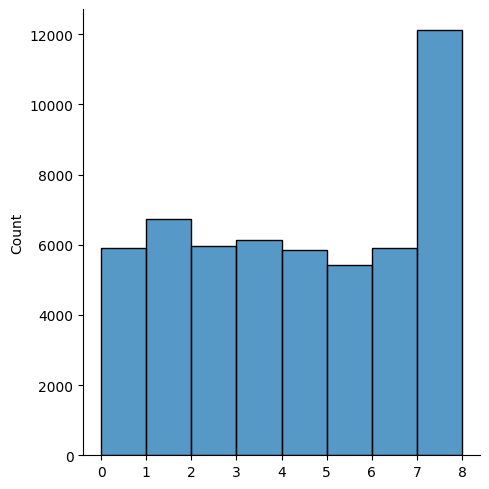

<IPython.core.display.Javascript object>

In [5]:
sns.displot(y_train, bins=(range(0, 9)))

In [6]:
inp_shape = x_train[0].shape
inp_shape

(28, 28)

<IPython.core.display.Javascript object>

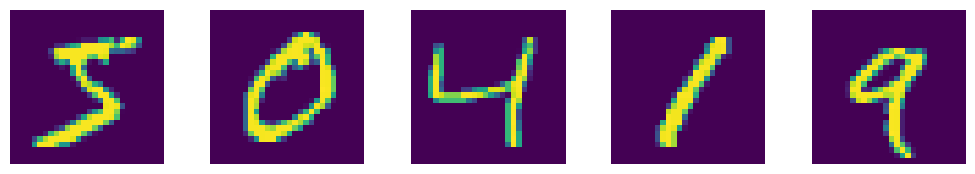

<IPython.core.display.Javascript object>

In [7]:
plot_images(x_train[:5])

In [8]:
COLUMN_SPARSITY = 0.2
COLUMN_DIM = (46, 46)

<IPython.core.display.Javascript object>

In [9]:
sp = SpatialPooler(
    input_dimension=inp_shape,
    column_dimension=COLUMN_DIM,
    connection_sparsity=0.4,
    permanence_threshold=0.5,
    stimulus_threshold=25.0,
    permanence_increment=0.1,
    permanence_decrement=0.02,
    column_sparsity=COLUMN_SPARSITY,
)

<IPython.core.display.Javascript object>

In [10]:
samples = sample_class(x_train, y_train, 5, 1000, False)
samples = encode_img(samples)

<IPython.core.display.Javascript object>

In [11]:
for sample in tqdm(samples):
    sp.compute(sample, learn=True)
sp.save_state("sp_state")

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [26]:
ref_five, test_five = get_sp_sdr_test_set(sp, x_train, y_train, 5, False)

<IPython.core.display.Javascript object>

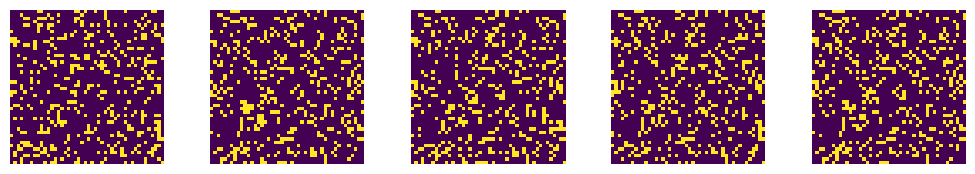

<IPython.core.display.Javascript object>

In [27]:
plot_images(ref_five.reshape((5, 46, 46)))

In [28]:
sim = get_similiraty(ref_five, test_five)
mean_sim = get_mean_similiraty(ref_five, test_five)
sim_percent = similiraty_to_percent(mean_sim, COLUMN_SPARSITY, np.prod(COLUMN_DIM))

print(f"similiraty scores: {sim}")
print(f"mean similiraty: {mean_sim}")
print(f"similiraty in %: {sim_percent:.2%}")

similiraty scores: [333. 252. 294. 294. 246.]
mean similiraty: 283.8
similiraty in %: 67.06%


<IPython.core.display.Javascript object>

In [33]:
ref_six, test_six = get_sp_sdr_test_set(sp, x_train, y_train, 1, False)

<IPython.core.display.Javascript object>

In [34]:
sim = get_similiraty(ref_six, test_six)
mean_sim = get_mean_similiraty(ref_six, test_six)
sim_percent = similiraty_to_percent(mean_sim, COLUMN_SPARSITY, np.prod(COLUMN_DIM))

print(f"similiraty scores: {sim}")
print(f"mean similiraty: {mean_sim}")
print(f"similiraty in %: {sim_percent:.2%}")

similiraty scores: [289. 338. 328. 314. 296.]
mean similiraty: 313.0
similiraty in %: 73.96%


<IPython.core.display.Javascript object>